In [5]:
# ----------------------------
# CELL 1: imports / setup
# ----------------------------
import sys
import os

project_root = os.path.abspath("..")
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from config import *
from Data.raw_data_loader import load_raw_crypto_csv
from Models.zscore import zscore_signal
from Models.ou import ou_signal              # FIXED (was ou_signal_on_spread)
from Models.trend import trend_signal
from Models.mining import mining_signal
from Backtest.engine import run_backtest
from Backtest.metrics import build_summary_table, rolling_sharpe

plt.style.use("default")

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# ----------------------------
# CELL 2: load / clean data
# ----------------------------
df = load_raw_crypto_csv(DATA_PATH, start_date=DATA_START_DATE)   # FIXED (added start_date)

df = df[(df["BTC-USD_close"] > 0)].copy()

btc_ret = df["BTC-USD_close"].pct_change()
df = df[btc_ret.abs() < 1.0]   # remove extreme data errors

print("Shape:", df.shape)
print("Start:", df.index.min(), "End:", df.index.max())

Shape: (3019, 12)
Start: 2017-11-02 00:00:00 End: 2026-02-09 00:00:00


In [ ]:
# ----------------------------
# CELL 3: base model positions (FIXED to match your Models/* signatures)
# ----------------------------
import config as cfg

# Z-score model (expects df)
z_pos = zscore_signal(
    df,
    price_column=cfg.PRICE_COLUMN_BTC,
    resid_window=cfg.ZSCORE_WINDOW,
    entry_z=cfg.ZSCORE_ENTRY_Z,
    exit_z=cfg.ZSCORE_EXIT_Z,
    long_short=cfg.ZSCORE_LONG_SHORT,
    filter_fast=cfg.TREND_FAST_WINDOW,
    filter_slow=cfg.TREND_SLOW_WINDOW,
    use_vol_target=cfg.USE_VOL_TARGET,
    vol_target=cfg.VOL_TARGET,
    vol_window=cfg.VOL_WINDOW,
    max_leverage=cfg.LEVERAGE_CAP,
).shift(1).fillna(0.0)

# OU model (expects Series)
ou_pos = ou_signal(
    df[cfg.PRICE_COLUMN_BTC],
    window=cfg.OU_WINDOW,
    entry_z=cfg.OU_ENTRY_Z,
    exit_z=cfg.OU_EXIT_Z,
    long_short=cfg.OU_LONG_SHORT,
).shift(1).fillna(0.0)

# Trend model (expects df)
trend_pos = trend_signal(
    df,
    price_column=cfg.PRICE_COLUMN_BTC,
    fast_window=cfg.TREND_FAST_WINDOW,
    slow_window=cfg.TREND_SLOW_WINDOW,
    long_only=cfg.TREND_LONG_ONLY,
    leverage_aggressive=cfg.TREND_AGGRESSIVE,
    leverage_neutral=cfg.TREND_NEUTRAL,
    leverage_defensive=cfg.TREND_DEFENSIVE,
).shift(1).fillna(0.0)

# Mining model (expects df; NO long_short arg)
mining_pos = mining_signal(
    df,
    z_window=cfg.MINING_Z_WINDOW,
    entry_z=cfg.MINING_ENTRY_Z,
    exit_z=cfg.MINING_EXIT_Z,
    use_log_edge=cfg.MINING_USE_LOG_EDGE,
).shift(1).fillna(0.0)

print("Mean abs positions:",
      "z", float(z_pos.abs().mean()),
      "ou", float(ou_pos.abs().mean()),
      "trend", float(trend_pos.abs().mean()),
      "mining", float(mining_pos.abs().mean()))

Mean abs positions: z 0.9844319311030142 ou 0.9506459092414706 trend 1.0221265319642265 mining 0.33487909903941704


In [ ]:
# ----------------------------
# CELL 4: stochastic tactical + combos
# ----------------------------
btc_buy_hold_pos = pd.Series(1.0, index=df.index, dtype=float)

def clip_pos(pos: pd.Series) -> pd.Series:
    return pos.clip(-LEVERAGE_CAP, LEVERAGE_CAP)

# BTC stochastic-style tactical model
def btc_stochastic_tactical_signal(df: pd.DataFrame) -> pd.Series:
    price = df["BTC-USD_close"].astype(float)
    cost = df["COST_TO_MINE"].replace(0.0, np.nan).astype(float)

    valuation_ratio = price / cost
    log_price = np.log(price.replace(0.0, np.nan))
    ou_z = (log_price - log_price.rolling(90).mean()) / log_price.rolling(90).std()

    ma_200 = price.rolling(200).mean()
    regime_trend = (price > ma_200).astype(float)

    signal = pd.Series(0.0, index=df.index, dtype=float)
    signal.loc[valuation_ratio < 1.05] = 1.0
    signal.loc[(regime_trend == 0.0) & (ou_z < -1.5)] = 1.0
    signal.loc[(regime_trend == 1.0) & (ou_z > -0.5)] = 1.0
    signal.loc[(ou_z > 2.0) & (valuation_ratio > 2.0)] = 0.0

    return signal.shift(1).fillna(0.0)

stochastic_pos = btc_stochastic_tactical_signal(df)

# combos
z_ou_pos = clip_pos(0.00 * z_pos + 0.40 * ou_pos + 0.60 * stochastic_pos)
ou_trend_pos = clip_pos(0.20 * ou_pos + 0.40 * trend_pos + 0.75 * stochastic_pos)
all_models_pos = clip_pos(0.60 * z_pos + 0.00 * ou_pos + 0.00 * trend_pos + 0.80 * stochastic_pos)

In [ ]:
# ----------------------------
# CELL 5: run backtests
# ----------------------------
buy_hold_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=btc_buy_hold_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

stochastic_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=stochastic_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

z_ou_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=z_ou_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

ou_trend_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=ou_trend_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

all_models_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=all_models_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

In [ ]:
# ----------------------------
# CELL 6: summary table  (FIXED brackets)
# ----------------------------
summary = build_summary_table({
    "BTC Buy & Hold": {
        "returns": buy_hold_results["net_returns"],
        "position": btc_buy_hold_pos,
    },
    "Stochastic Tactical": {
        "returns": stochastic_results["net_returns"],
        "position": stochastic_pos,
    },
    "Z-Score + OU": {
        "returns": z_ou_results["net_returns"],
        "position": z_ou_pos,
    },
    "OU + Trend": {
        "returns": ou_trend_results["net_returns"],
        "position": ou_trend_pos,
    },
    "Grand Combo (All Models)": {
        "returns": all_models_results["net_returns"],
        "position": all_models_pos,
    },
})

summary

,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
Strategy,,,,,,,,,
BTC Buy & Hold,0.753704,1.020556,0.320936,-0.833990,0.384820,0.502618,0.666864,3019,0.000000
Stochastic Tactical,1.161993,1.406231,0.624292,-0.542021,1.151784,0.637798,0.548883,3019,16.563432
Z-Score + OU,1.021916,1.340843,0.511053,-0.640032,0.798480,0.570879,0.558636,3019,9.986419
OU + Trend,1.030092,1.373626,0.632431,-0.760722,0.831357,0.803453,0.779982,3019,13.118963
Grand Combo (All Models),1.168752,1.423510,0.689150,-0.669493,1.029361,0.723824,0.619314,3019,17.433919


In [ ]:
# ----------------------------
# CELL 6.5: run base backtests and create *_results dicts
# (must run before the equity plot cell)
# ----------------------------
import config as cfg

def run_backtest_from_position(price: pd.Series, pos: pd.Series, fee_bps: float, slippage_bps: float) -> dict:
    """
    Minimal backtest to produce the keys your plot cell expects:
      - net_equity
      - net_ret
    Uses: net_ret = pos.shift(0) * price.pct_change() - costs
    Costs: (fee+slippage) applied on turnover |Δpos|.
    """
    price = price.astype(float)
    ret = price.pct_change().fillna(0.0)

    pos = pos.reindex(price.index).fillna(0.0)

    # turnover costs
    turn = pos.diff().abs().fillna(0.0)
    cost = (fee_bps + slippage_bps) / 1e4 * turn

    net_ret = (pos * ret) - cost
    net_equity = (1.0 + net_ret).cumprod()

    return {
        "net_ret": net_ret,
        "net_equity": net_equity,
        "turnover": turn,
    }

# price
price_btc = df[cfg.PRICE_COLUMN_BTC].astype(float)

# buy & hold
buy_hold_pos = pd.Series(1.0, index=price_btc.index)
buy_hold_results = run_backtest_from_position(price_btc, buy_hold_pos, fee_bps=0.0, slippage_bps=0.0)

# base models (positions should already exist from your "CELL 3")
z_results = run_backtest_from_position(price_btc, z_pos, cfg.FEE_BPS, cfg.SLIPPAGE_BPS)
ou_results = run_backtest_from_position(price_btc, ou_pos, cfg.FEE_BPS, cfg.SLIPPAGE_BPS)
trend_results = run_backtest_from_position(price_btc, trend_pos, cfg.FEE_BPS, cfg.SLIPPAGE_BPS)
mining_results = run_backtest_from_position(price_btc, mining_pos, cfg.FEE_BPS, cfg.SLIPPAGE_BPS)

print("Built results:", [k for k in ["z_results","ou_results","trend_results","mining_results","buy_hold_results"] if k in globals()])

Built results: ['z_results', 'ou_results', 'trend_results', 'mining_results', 'buy_hold_results']


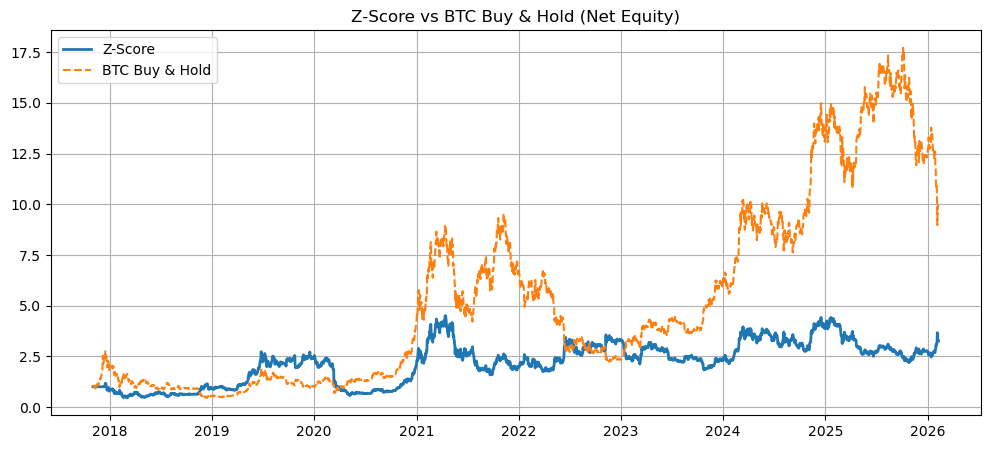

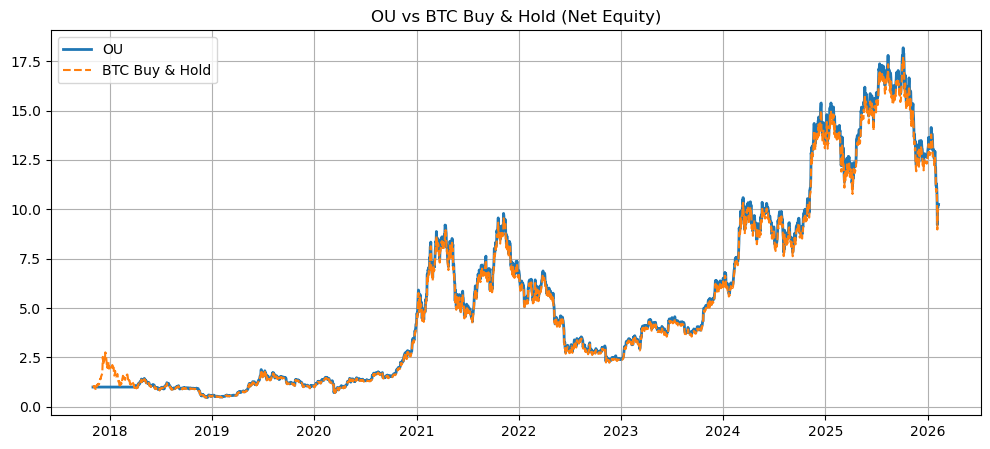

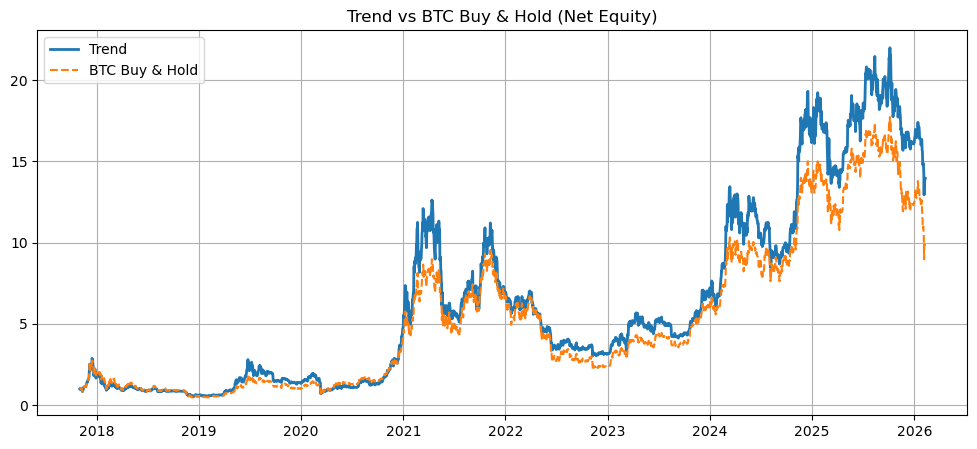

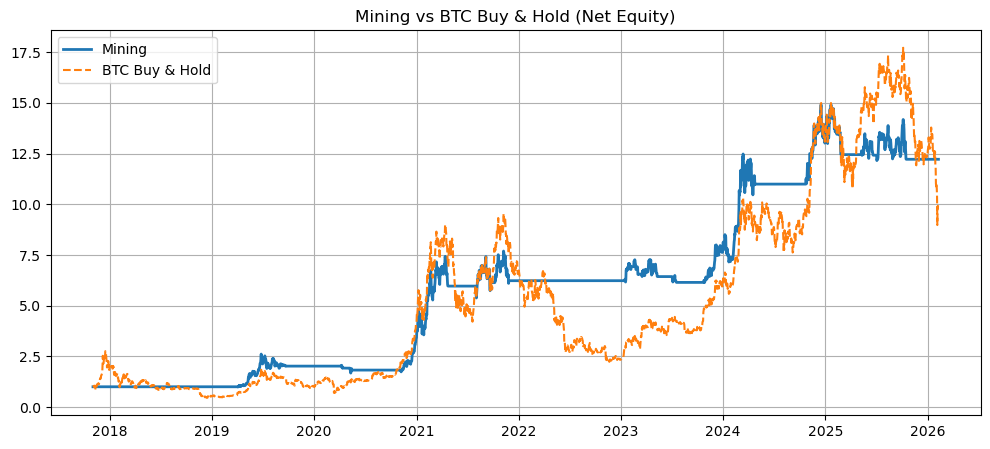

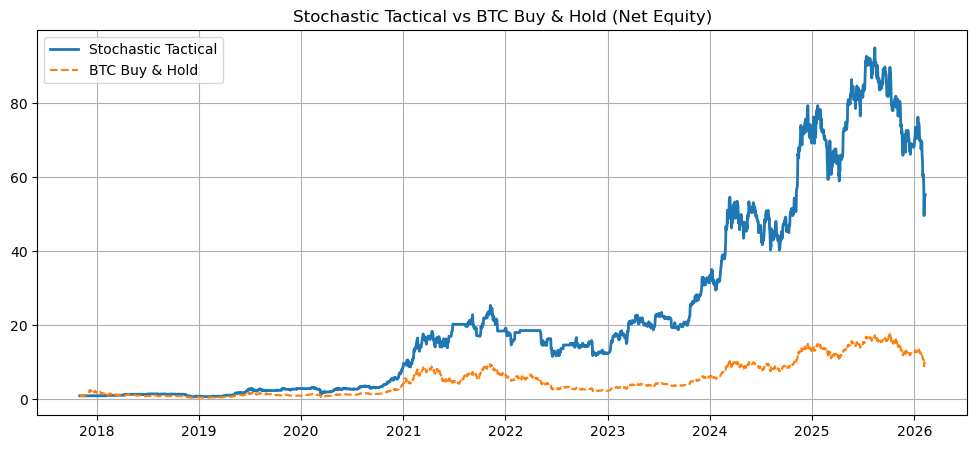

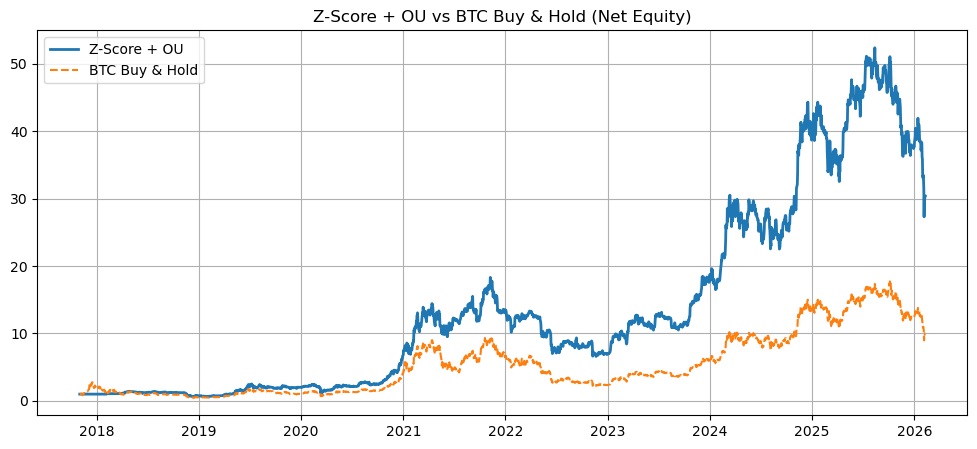

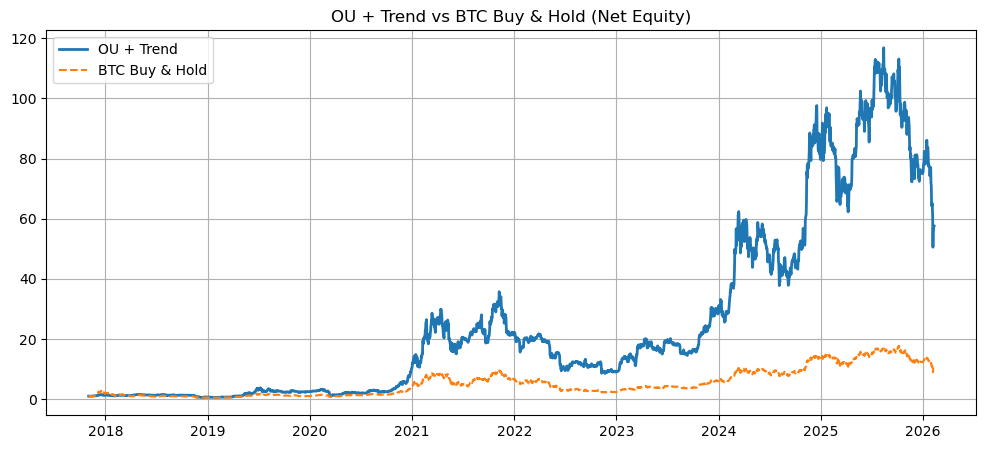

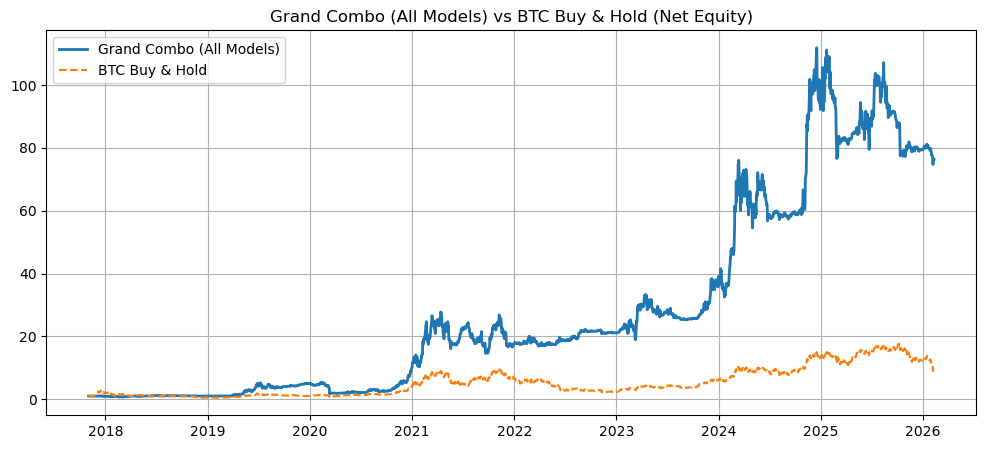

In [ ]:
# ----------------------------
# CELL 7: equity plots (safe)
# ----------------------------
import matplotlib.pyplot as plt

strategy_equity = {
    "Z-Score": z_results["net_equity"],
    "OU": ou_results["net_equity"],
    "Trend": trend_results["net_equity"],
    "Mining": mining_results["net_equity"],
}

# Optional combos: only include if they exist
optional = {
    "Stochastic Tactical": "stochastic_results",
    "Z-Score + OU": "z_ou_results",
    "OU + Trend": "ou_trend_results",
    "Grand Combo (All Models)": "all_models_results",
}
for name, var in optional.items():
    if var in globals() and isinstance(globals()[var], dict) and "net_equity" in globals()[var]:
        strategy_equity[name] = globals()[var]["net_equity"]

for name, eq in strategy_equity.items():
    plt.figure(figsize=(12, 5))
    plt.plot(eq, label=name, linewidth=2.0)
    plt.plot(buy_hold_results["net_equity"], label="BTC Buy & Hold", linestyle="--")
    plt.title(f"{name} vs BTC Buy & Hold (Net Equity)")
    plt.legend()
    plt.grid(True)
    plt.show()

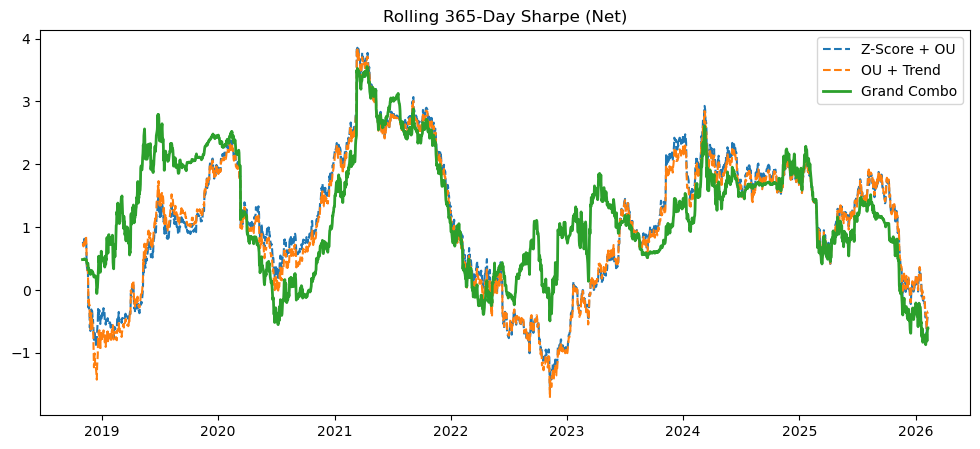

In [ ]:
# ----------------------------
# CELL 8: rolling sharpe plot (FIXED extra plt.show)
# ----------------------------
plt.figure(figsize=(12, 5))
plt.plot(rolling_sharpe(z_ou_results["net_returns"], window=365), label="Z-Score + OU", linestyle="--")
plt.plot(rolling_sharpe(ou_trend_results["net_returns"], window=365), label="OU + Trend", linestyle="--")
plt.plot(rolling_sharpe(all_models_results["net_returns"], window=365), label="Grand Combo", linewidth=2.0)
plt.title("Rolling 365-Day Sharpe (Net)")
plt.legend()
plt.show()

In [ ]:
# ----------------------------
# Define drawdown function
# ----------------------------
def drawdown(equity: pd.Series) -> pd.Series:
    """
    Computes drawdown series from equity curve.
    Drawdown = equity / running_max - 1
    """
    equity = equity.astype(float)
    running_max = equity.cummax()
    dd = equity / running_max - 1.0
    return dd

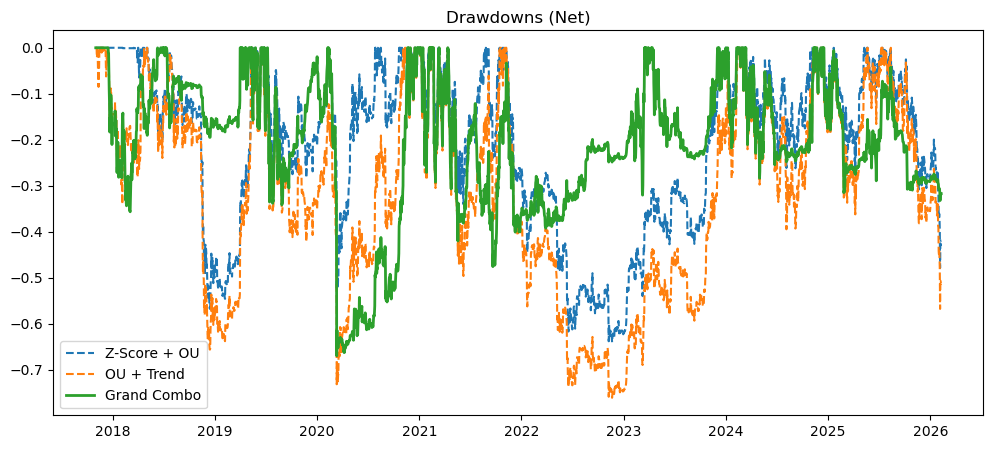

In [ ]:
# ----------------------------
# CELL 9: drawdowns (FIXED extra plt.show)
# NOTE: requires drawdown() to be defined/imported in your notebook.
# ----------------------------
plt.figure(figsize=(12, 5))
plt.plot(drawdown(z_ou_results["net_equity"]), label="Z-Score + OU", linestyle="--")
plt.plot(drawdown(ou_trend_results["net_equity"]), label="OU + Trend", linestyle="--")
plt.plot(drawdown(all_models_results["net_equity"]), label="Grand Combo", linewidth=2.0)
plt.title("Drawdowns (Net)")
plt.legend()
plt.show()

In [ ]:
# ----------------------------
# Define annual_turnover
# ----------------------------
import config as cfg

def annual_turnover(pos: pd.Series, days_per_year: int = cfg.DAYS_PER_YEAR) -> float:
    """
    Annualized turnover:
        mean(|Δposition|) * days_per_year
    """
    pos = pos.fillna(0.0)
    turn = pos.diff().abs().fillna(0.0)
    return float(turn.mean() * days_per_year)

In [ ]:
# ----------------------------
# CELL 10: turnover prints (FIXED duplicate mining line)
# NOTE: requires annual_turnover() to be defined/imported.
# ----------------------------
print("Annual Turnover Buy&Hold:", annual_turnover(buy_hold_pos))
print("Annual Turnover Z:", annual_turnover(z_pos))
print("Annual Turnover OU:", annual_turnover(ou_pos))
print("Annual Turnover Trend:", annual_turnover(trend_pos))
print("Annual Turnover Mining:", annual_turnover(mining_pos))
print("Annual Turnover Stochastic Tactical:", annual_turnover(stochastic_pos))
print("Annual Turnover Z+OU:", annual_turnover(z_ou_pos))
print("Annual Turnover OU+Trend:", annual_turnover(ou_trend_pos))
print("Annual Turnover Grand Combo:", annual_turnover(all_models_pos))

Annual Turnover Buy&Hold: 0.0
Annual Turnover Z: 7.6167605167273935
Annual Turnover OU: 0.1209009605829745
Annual Turnover Trend: 1.9706856575024847
Annual Turnover Mining: 4.110632659821133
Annual Turnover Stochastic Tactical: 16.563431599867506
Annual Turnover Z+OU: 9.986419344153692
Annual Turnover OU+Trend: 13.118963232858563
Annual Turnover Grand Combo: 17.43391851606492


In [ ]:
# ----------------------------
# CELL 11: alpha diagnostics (as-is, but clean cell)
# ----------------------------
def alpha_diagnostics(strategy_returns: pd.Series, benchmark_returns: pd.Series) -> dict:
    aligned = pd.concat([strategy_returns, benchmark_returns], axis=1).dropna()
    aligned.columns = ["strategy", "benchmark"]

    excess = aligned["strategy"] - aligned["benchmark"]
    alpha_ann = float(excess.mean() * 365)
    info_ratio = float((excess.mean() / excess.std(ddof=1)) * np.sqrt(365)) if excess.std(ddof=1) > 0 else np.nan

    return {
        "Alpha_Annualized": alpha_ann,
        "InformationRatio": info_ratio,
    }

def get_ret(results_dict):
    return results_dict.get("net_ret", results_dict.get("net_returns"))

combo_alpha = pd.DataFrame({
    "Z-Score + OU": alpha_diagnostics(get_ret(z_ou_results), get_ret(buy_hold_results)),
    "OU + Trend": alpha_diagnostics(get_ret(ou_trend_results), get_ret(buy_hold_results)),
    "Grand Combo (All Models)": alpha_diagnostics(get_ret(all_models_results), get_ret(buy_hold_results)),
}).T

combo_alpha

,Alpha_Annualized,InformationRatio
Z-Score + OU,0.068261,0.220275
OU + Trend,0.300835,1.020586
Grand Combo (All Models),0.221206,0.380797


In [ ]:
# ----------------------------
# FINAL CELL A: Trend + Mining (0.5 / 0.5) position + backtest
# Requires: trend_pos, mining_pos, run_backtest_from_position, sharpe (or compute here), cfg
# ----------------------------
import config as cfg
import numpy as np
import pandas as pd

# 0.5 / 0.5 linear combo
trend_mining_pos = (0.5 * trend_pos + 0.5 * mining_pos).clip(-cfg.LEVERAGE_CAP, cfg.LEVERAGE_CAP)
trend_mining_pos = trend_mining_pos.shift(1).fillna(0.0)

price_btc = df[cfg.PRICE_COLUMN_BTC].astype(float)

trend_mining_results = run_backtest_from_position(
    price=price_btc,
    pos=trend_mining_pos,
    fee_bps=cfg.FEE_BPS,
    slippage_bps=cfg.SLIPPAGE_BPS,
)

trend_mining_sharpe = np.sqrt(cfg.DAYS_PER_YEAR) * trend_mining_results["net_ret"].mean() / trend_mining_results["net_ret"].std()

print("Sharpe (Trend + Mining 0.5/0.5) net:", float(trend_mining_sharpe))
trend_mining_results["net_equity"].tail()

Sharpe (Trend + Mining 0.5/0.5) net: 0.9673829563842565


Date
2026-02-05    17.864053
2026-02-06    18.507143
2026-02-07    18.461886
2026-02-08    18.573215
2026-02-09    18.570551
dtype: float64

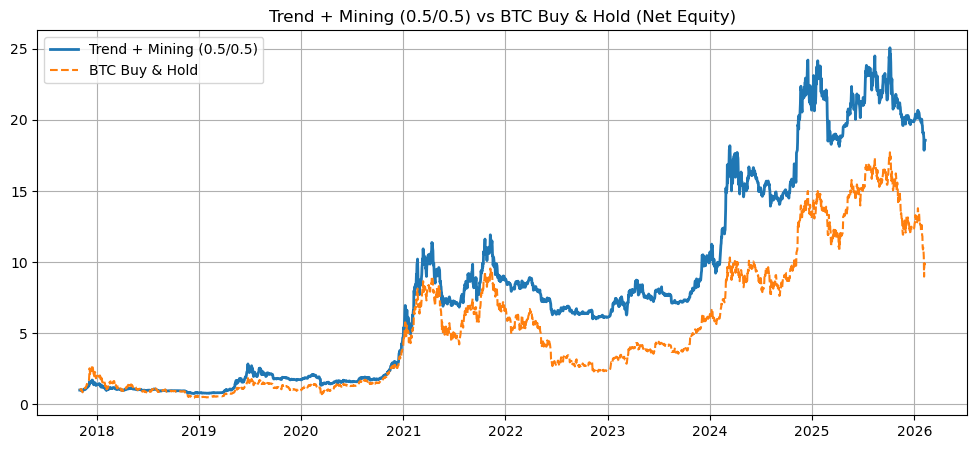

In [ ]:
# ----------------------------
# FINAL CELL B: Plot equity curve (Trend+Mining) vs Buy&Hold
# Requires: buy_hold_results, trend_mining_results
# ----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(trend_mining_results["net_equity"], label="Trend + Mining (0.5/0.5)", linewidth=2.0)
plt.plot(buy_hold_results["net_equity"], label="BTC Buy & Hold", linestyle="--")
plt.title("Trend + Mining (0.5/0.5) vs BTC Buy & Hold (Net Equity)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ----------------------------
# Try adding OU to Trend+Mining only if it improves Sharpe
# ----------------------------
import numpy as np

def sr(x: pd.Series) -> float:
    x = x.dropna()
    if x.std() == 0 or len(x) < 10:
        return np.nan
    return float(np.sqrt(cfg.DAYS_PER_YEAR) * x.mean() / x.std())

base_sr = sr(trend_mining_results["net_ret"])

alphas = np.linspace(0.0, 1.0, 21)

best = {
    "alpha_ou": 0.0,
    "sr": base_sr,
    "pos": trend_mining_pos,
    "results": trend_mining_results,
    "label": "Trend+Mining (0.5/0.5)"
}

ou_pos_aligned = ou_pos.reindex(price_btc.index).fillna(0.0)

for a in alphas:
    combo_pos = ((1 - a) * trend_mining_pos + a * ou_pos_aligned).clip(-cfg.LEVERAGE_CAP, cfg.LEVERAGE_CAP)
    combo_pos = combo_pos.shift(1).fillna(0.0)

    combo_results = run_backtest_from_position(
        price=price_btc,
        pos=combo_pos,
        fee_bps=cfg.FEE_BPS,
        slippage_bps=cfg.SLIPPAGE_BPS,
    )

    combo_sr = sr(combo_results["net_ret"])

    if np.isfinite(combo_sr) and combo_sr > best["sr"] + 1e-6:
        best = {
            "alpha_ou": float(a),
            "sr": float(combo_sr),
            "pos": combo_pos,
            "results": combo_results,
            "label": f"Trend+Mining+OU (best a={a:.2f})"
        }

print("Base Trend+Mining Sharpe:", base_sr)
print("Best Sharpe after adding OU:", best["sr"])
print("Selected model:", best["label"])

best_combo_pos = best["pos"]
best_combo_results = best["results"]

Base Trend+Mining Sharpe: 0.9673829563842565
Best Sharpe after adding OU: 0.9673829563842565
Selected model: Trend+Mining (0.5/0.5)


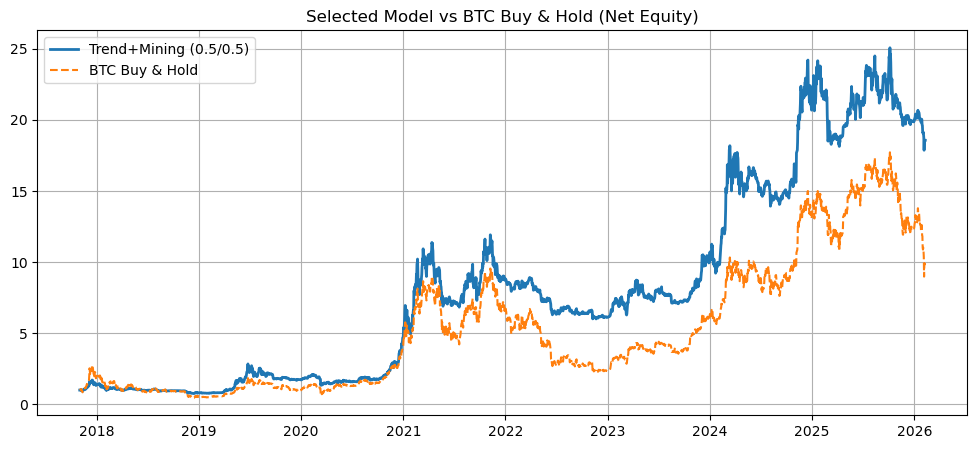

In [ ]:
# ----------------------------
# Equity curve: selected model vs Buy&Hold
# ----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(best_combo_results["net_equity"], label=best["label"], linewidth=2.0)
plt.plot(buy_hold_results["net_equity"], label="BTC Buy & Hold", linestyle="--")
plt.title("Selected Model vs BTC Buy & Hold (Net Equity)")
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [20]:
# ----------------------------
# Robust trading_engine path fix (works across CWD changes)
# ----------------------------
import sys
import site
from pathlib import Path


def find_engine_src() -> Path:
    """Find <repo_root>/trading-engine/src by searching upward from CWD."""
    start = Path().resolve()
    for candidate in [start, *start.parents]:
        engine_pkg = candidate / "trading-engine" / "src" / "trading_engine"
        if engine_pkg.exists():
            return engine_pkg.parent
    raise FileNotFoundError(
        "Could not locate trading-engine/src/trading_engine from current working directory"
    )


ENGINE_SRC = find_engine_src()

# Primary fix: inject src at the front of sys.path
if str(ENGINE_SRC) not in sys.path:
    sys.path.insert(0, str(ENGINE_SRC))

# Fallback: if import still fails in some kernels, uncomment the next line
# site.addsitedir(str(ENGINE_SRC))



ENGINE_SRC: /Users/samgeng14/PycharmProjects/LunaExchange/Crypto/trading-engine/src
exists: False
python: /Users/samgeng14/PycharmProjects/LunaExchange/.venv/bin/python
sys.path[0]: /Users/samgeng14/PycharmProjects/LunaExchange/Crypto/trading-engine/src


ModuleNotFoundError: No module named 'trading_engine'

In [ ]:
# ----------------------------
# Sanity check for interpreter, CWD, and import origin
# ----------------------------
import os
import sys

print("sys.executable:", sys.executable)
print("os.getcwd():", os.getcwd())
print("ENGINE_SRC:", ENGINE_SRC)
print("ENGINE_SRC.exists():", ENGINE_SRC.exists())

import trading_engine
print("trading_engine.__file__:", trading_engine.__file__)

from trading_engine.core import run_full_backtest
print("core import ok:", run_full_backtest.__name__)



In [ ]:
# ==================================================
# CELL B: Choose production universe/features/models
# (Prefer loading from your production yaml if you have it.
#  If not, use the fallback lists below.)
# ==================================================
import os
import yaml

def try_load_prod_config(path_candidates):
    for p in path_candidates:
        if os.path.exists(p):
            with open(p, "r") as f:
                return yaml.safe_load(f), p
    return None, None

cfg, cfg_path = try_load_prod_config([
    "src/production/paper/config.yaml",
    "../src/production/paper/config.yaml",
    "../../src/production/paper/config.yaml",
])

if cfg is not None:
    print("Loaded config:", cfg_path)
    UNIVERSE = cfg["universe"]
    FEATURES = cfg["model_state_features"]
    ENGINE_MODELS = cfg["models"]
    ENGINE_AGGS = cfg.get("aggregators", [DEFAULT_AGG])
    ENGINE_OPTS = cfg.get("portfolio_optimizers", None)
else:
    print("No production config found. Using fallback lists.")
    # Fallback: keep this small + include crypto proxies if your engine has them.
    UNIVERSE = ["SPY-US", "TLT-US", "GLD-US", "IBIT-US", "ETHA-US"]
    # FEATURES must match your FEATURE registry; keep whatever your pipeline already uses.
    # If you already have FEATURES in your notebook, replace this with your list.
    FEATURES = [
        "adjusted_close_1d",
        "close_momentum_10",
        "close_momentum_60",
        "close_momentum_240",
    ]
    # Pick a small set of existing engine models (must exist in MODELS registry).
    # If you already run a specific model list, use it instead.
    ENGINE_MODELS = [k for k in list(MODELS.keys())[:15]]
    ENGINE_AGGS = [DEFAULT_AGG]
    ENGINE_OPTS = None

print("Universe size:", len(UNIVERSE))
print("Models size:", len(ENGINE_MODELS))
print("Aggs:", ENGINE_AGGS)
print("Opts:", ENGINE_OPTS)

In [ ]:
# ===========================================
# CELL C: Run the trading-engine base portfolio
# (This is the portfolio WITHOUT your crypto model)
# ===========================================
base_results = run_full_backtest(
    universe=UNIVERSE,
    features=FEATURES,
    models=ENGINE_MODELS,
    aggregators=ENGINE_AGGS,
    optimizers=ENGINE_OPTS,
    start_date=START_DATE,
    end_date=END_DATE,
    initial_value=INITIAL_VALUE,
    fee_model=FEE_MODEL,
    slippage_bps=SLIPPAGE_BPS,
)

# Pick the first aggregation simulation (most setups have 1 aggregator)
base_agg_name = list(base_results["aggregation_simulations"].keys())[0]
base_bt = base_results["aggregation_simulations"][base_agg_name]

print("Base portfolio aggregator:", base_agg_name)
print("Base backtest keys:", list(base_bt.keys())[:15], "...")

In [ ]:
# ==========================================================
# CELL D: Helpers to extract equity/returns + compute metrics
# (Robust to different HawkBacktester output key names.)
# ==========================================================
def _first_present(d, keys):
    for k in keys:
        if k in d:
            return k
    return None

def extract_equity_series(backtest_dict):
    """
    Returns: pd.Series indexed by datetime-like (or integer index if dates not available).
    Tries common HawkBacktester key patterns.
    """
    # candidate key sets
    eq_key = _first_present(backtest_dict, [
        "equity_curve", "equity", "portfolio_value", "account_value", "nav", "values"
    ])
    if eq_key is None:
        raise KeyError(f"Couldn't find equity series in backtest dict. Keys: {list(backtest_dict.keys())}")

    eq = backtest_dict[eq_key]

    # If already a DataFrame-like
    if isinstance(eq, (pl.DataFrame, pl.Series)):
        eq = eq.to_pandas()
    if isinstance(eq, pd.DataFrame):
        # guess column
        col = None
        for c in ["equity", "value", "portfolio_value", "nav"]:
            if c in eq.columns:
                col = c
                break
        if col is None:
            col = eq.columns[-1]
        s = eq[col]
        if "date" in eq.columns:
            s.index = pd.to_datetime(eq["date"])
        return s

    # If list/np array
    s = pd.Series(eq)
    # try to pull dates
    date_key = _first_present(backtest_dict, ["dates", "date", "index"])
    if date_key is not None:
        dates = backtest_dict[date_key]
        try:
            s.index = pd.to_datetime(dates)
        except Exception:
            pass
    return s

def extract_daily_returns(backtest_dict):
    ret_key = _first_present(backtest_dict, [
        "daily_returns", "returns", "pnl_returns", "strategy_returns"
    ])
    if ret_key is not None:
        r = backtest_dict[ret_key]
        if isinstance(r, (pl.Series, pl.DataFrame)):
            r = r.to_pandas()
        if isinstance(r, pd.DataFrame):
            col = r.columns[-1]
            s = r[col].copy()
            if "date" in r.columns:
                s.index = pd.to_datetime(r["date"])
            return s
        return pd.Series(r)

    # Fallback: compute from equity
    eq = extract_equity_series(backtest_dict).astype(float)
    r = eq.pct_change().fillna(0.0)
    r.name = "daily_returns"
    return r

def perf_stats(daily_returns, days_per_year=252):
    r = pd.Series(daily_returns).dropna()
    if len(r) < 5:
        return {"sharpe": np.nan, "cagr": np.nan, "vol": np.nan, "max_dd": np.nan}

    mean = r.mean()
    vol = r.std(ddof=1)
    sharpe = (mean / vol) * np.sqrt(days_per_year) if vol > 0 else np.nan

    eq = (1.0 + r).cumprod()
    years = len(r) / days_per_year
    cagr = eq.iloc[-1] ** (1 / years) - 1 if years > 0 else np.nan

    peak = eq.cummax()
    dd = (eq / peak) - 1.0
    max_dd = dd.min()

    return {"sharpe": sharpe, "cagr": cagr, "vol": vol * np.sqrt(days_per_year), "max_dd": max_dd}

# Base series + stats
base_eq = extract_equity_series(base_bt)
base_rets = extract_daily_returns(base_bt)
base_stats = perf_stats(base_rets)

base_stats

In [ ]:
# ==========================================================
# CELL E: Your crypto model weights (trend + mining [+ optional OU])
#
# Assumptions:
# - You already computed these in earlier Research 02 cells:
#     trend_pos, mining_pos, ou_pos  (pd.Series indexed by date)
#
# If your signals are named differently, map them here.
# ==========================================================
def _to_pd_series(x, name=None):
    if isinstance(x, pd.Series):
        s = x.copy()
    elif isinstance(x, (pl.Series, pl.DataFrame)):
        s = x.to_pandas().squeeze()
    else:
        s = pd.Series(x)
    if name:
        s.name = name
    return s

# REQUIRED: use your existing series from the notebook
trend_pos_s  = _to_pd_series(trend_pos,  "trend_pos")
mining_pos_s = _to_pd_series(mining_pos, "mining_pos")

# Optional:
ou_pos_s = None
if "ou_pos" in globals():
    ou_pos_s = _to_pd_series(ou_pos, "ou_pos")

# Align indices
idx = trend_pos_s.index
mining_pos_s = mining_pos_s.reindex(idx).fillna(0.0)

# Base crypto model = 0.5 trend + 0.5 mining (your request)
tm_pos = 0.5 * trend_pos_s + 0.5 * mining_pos_s
tm_pos = tm_pos.clip(-1.0, 1.0).fillna(0.0)

# Candidate = add OU (equal weights across 3, then clip)
if ou_pos_s is not None:
    ou_pos_s = ou_pos_s.reindex(idx).fillna(0.0)
    tmo_pos = (trend_pos_s + mining_pos_s + ou_pos_s) / 3.0
    tmo_pos = tmo_pos.clip(-1.0, 1.0).fillna(0.0)
else:
    tmo_pos = None

# Decide which ticker in the engine universe represents BTC exposure
BTC_LIKE = None
for cand in ["IBIT-US", "BTC-USD", "BTC-US", "BTC", "BTC-USD_close"]:
    if cand in UNIVERSE:
        BTC_LIKE = cand
        break

if BTC_LIKE is None:
    raise ValueError(
        "Couldn't find a BTC-like ticker in UNIVERSE. "
        "Add 'IBIT-US' (recommended) or map your BTC proxy name."
    )

print("Using BTC proxy ticker:", BTC_LIKE)

In [ ]:
# ==========================================================
# CELL F: Convert your model series -> engine-style weights DF
# (wide: date + universe columns)
# ==========================================================
def series_to_engine_weights(signal_s: pd.Series, universe: list[str], trade_ticker: str) -> pl.DataFrame:
    s = signal_s.copy()
    # ensure datetime index
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index)

    df = pl.DataFrame({"date": s.index.strftime("%Y-%m-%d"), trade_ticker: s.values.astype(float)})

    # pad universe columns
    for t in universe:
        if t not in df.columns and t != "date":
            df = df.with_columns(pl.lit(0.0).alias(t))

    df = df.select(["date", *universe])  # enforce order (date + universe)
    return df

tm_weights_df = series_to_engine_weights(tm_pos, UNIVERSE, BTC_LIKE)

# We'll build a second candidate weights df for OU+trend+mining if available
tmo_weights_df = series_to_engine_weights(tmo_pos, UNIVERSE, BTC_LIKE) if tmo_pos is not None else None

tm_weights_df.head()

In [ ]:
# ==========================================================
# CELL G: Simulate "your model alone" inside the engine backtester
# (so we can compare Sharpe and decide whether to keep OU)
# ==========================================================
# We need prices to run orchestrate_portfolio_simulations.
# Reuse the engine-created prices from the base run by reconstructing them:
# They live in model backtests, but easiest is to re-run create_model_state if you already have it.
#
# Practical shortcut: pull prices from the base model simulations by re-running run_full_backtest is heavy.
# Instead: re-run a minimal backtest pipeline to obtain prices for simulation only.

from trading_engine.core import read_data, create_model_state, calculate_max_lookback

total_lookback_days = calculate_max_lookback(
    features=FEATURES,
    models=ENGINE_MODELS,
    aggregators=ENGINE_AGGS,
    optimizers=ENGINE_OPTS,
)

raw_data_bundle = read_data(include_supplemental=True)
model_state_bundle, prices_df = create_model_state(
    raw_data_bundle=raw_data_bundle,
    features=FEATURES,
    start_date=START_DATE,
    end_date=END_DATE,
    universe=UNIVERSE,
    total_lookback_days=total_lookback_days,
    return_bundle=True,
)

# Simulate trend+mining
tm_bt = orchestrate_portfolio_simulations(
    prices=prices_df,
    portfolio_insights={"trend_mining": tm_weights_df},
    start_date=START_DATE,
    end_date=END_DATE,
    initial_value=INITIAL_VALUE,
    fee_model=FEE_MODEL,
    slippage_bps=SLIPPAGE_BPS,
)["trend_mining"]

tm_stats = perf_stats(extract_daily_returns(tm_bt))

# If OU exists, simulate that candidate too
if tmo_weights_df is not None:
    tmo_bt = orchestrate_portfolio_simulations(
        prices=prices_df,
        portfolio_insights={"trend_mining_ou": tmo_weights_df},
        start_date=START_DATE,
        end_date=END_DATE,
        initial_value=INITIAL_VALUE,
        fee_model=FEE_MODEL,
        slippage_bps=SLIPPAGE_BPS,
    )["trend_mining_ou"]
    tmo_stats = perf_stats(extract_daily_returns(tmo_bt))
else:
    tmo_bt, tmo_stats = None, None

tm_stats, tmo_stats

In [ ]:
# ==========================================================
# CELL H: Pick the better crypto model (add OU only if better Sharpe)
# ==========================================================
use_ou = False
if tmo_stats is not None and np.isfinite(tmo_stats["sharpe"]) and np.isfinite(tm_stats["sharpe"]):
    use_ou = tmo_stats["sharpe"] > tm_stats["sharpe"]

chosen_name = "trend_mining_ou" if use_ou else "trend_mining"
chosen_weights = tmo_weights_df if use_ou else tm_weights_df
chosen_bt = tmo_bt if use_ou else tm_bt
chosen_stats = tmo_stats if use_ou else tm_stats

print("Chosen crypto model:", chosen_name)
chosen_stats

In [ ]:
# ==========================================================
# CELL I: Portfolio WITHOUT your model (base) vs WITH your model
#
# Approach:
# - Use the base run's aggregated weights as the "portfolio"
# - Create a new portfolio weights = base_portfolio_weights + alpha * chosen_weights
# - Re-simulate both on the same prices
#
# Note:
# orchestrate_portfolio_simulations expects portfolio_insights: {name: wide_df}
# ==========================================================
# Base portfolio weights from engine aggregation output:
base_weights_df = base_results["aggregation_results"][base_agg_name]

# Align to full date set in prices for safe joins
def align_weights_to_prices(prices_df: pl.DataFrame, weights_df: pl.DataFrame, universe: list[str]) -> pl.DataFrame:
    out = prices_df.select("date").join(weights_df, on="date", how="left").fill_null(0.0)
    # Ensure all universe cols exist
    for t in universe:
        if t not in out.columns and t != "date":
            out = out.with_columns(pl.lit(0.0).alias(t))
    return out.select(["date", *universe])

base_w = align_weights_to_prices(prices_df, base_weights_df, UNIVERSE)
model_w = align_weights_to_prices(prices_df, chosen_weights, UNIVERSE)

# Choose how much "capacity" you want to give to your model inside the portfolio.
# alpha=0.0 => no model, alpha=0.2 => 20% overlay (before L1 clamp inside backtester, if any).
ALPHA = 0.20

# Combine weights and enforce a simple L1 budget (optional)
combined_w = base_w.with_columns(
    [(pl.col(c) + ALPHA * pl.col(c + "_m")).alias(c)
     for c in UNIVERSE]
)

# To add model columns, make a suffixed frame then join:
model_w_suff = model_w.rename({c: f"{c}_m" for c in model_w.columns if c != "date"})
combined_w = base_w.join(model_w_suff, on="date", how="left").fill_null(0.0)
combined_w = combined_w.with_columns(
    [(pl.col(c) + ALPHA * pl.col(f"{c}_m")).alias(c) for c in UNIVERSE]
).select(["date", *UNIVERSE])

# Optional: normalize L1 exposure to 1.0 per day (keeps leverage stable)
abs_sum = pl.sum_horizontal([pl.col(c).abs() for c in UNIVERSE]).alias("_l1")
combined_w = combined_w.with_columns(abs_sum).with_columns(
    pl.when(pl.col("_l1") > 1.0).then(1.0 / pl.col("_l1")).otherwise(1.0).alias("_scale")
).with_columns([(pl.col(c) * pl.col("_scale")).alias(c) for c in UNIVERSE]).drop(["_l1", "_scale"])

# Simulate both portfolios
bt_compare = orchestrate_portfolio_simulations(
    prices=prices_df,
    portfolio_insights={
        "portfolio_base": base_w,
        "portfolio_plus_model": combined_w,
    },
    start_date=START_DATE,
    end_date=END_DATE,
    initial_value=INITIAL_VALUE,
    fee_model=FEE_MODEL,
    slippage_bps=SLIPPAGE_BPS,
)

bt_compare.keys()

In [ ]:
# ==========================================================
# CELL J: Plot equity curves + print Sharpe/CAGR/MaxDD
# ==========================================================
base_port_bt = bt_compare["portfolio_base"]
plus_port_bt = bt_compare["portfolio_plus_model"]

eq_base = extract_equity_series(base_port_bt)
eq_plus = extract_equity_series(plus_port_bt)

r_base = extract_daily_returns(base_port_bt)
r_plus = extract_daily_returns(plus_port_bt)

s_base = perf_stats(r_base)
s_plus = perf_stats(r_plus)

print("Portfolio (base):", s_base)
print("Portfolio (+model):", s_plus)
print("Incremental Sharpe:", s_plus["sharpe"] - s_base["sharpe"])

plt.figure(figsize=(12, 6))
plt.plot(eq_base.index, eq_base.values, label="Portfolio (base)")
plt.plot(eq_plus.index, eq_plus.values, label=f"Portfolio + {chosen_name} (alpha={ALPHA:.2f})")
plt.title("Equity Curves")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ==========================================================
# CELL K: Marginal / value-add analysis
# - Incremental return series
# - Information ratio (vs base)
# - Simple alpha/beta regression vs base (daily)
# ==========================================================
import statsmodels.api as sm

# Align
df_m = pd.concat([r_base.rename("base"), r_plus.rename("plus")], axis=1).dropna()
df_m["marginal"] = df_m["plus"] - df_m["base"]

m_stats = perf_stats(df_m["marginal"])
print("Marginal return stats:", m_stats)

# Information ratio = mean(active) / std(active) * sqrt(252)
active = df_m["marginal"]
ir = (active.mean() / active.std(ddof=1)) * np.sqrt(252) if active.std(ddof=1) > 0 else np.nan
print("Information ratio (active vs base):", ir)

# Alpha/Beta: plus ~ alpha + beta * base
X = sm.add_constant(df_m["base"])
y = df_m["plus"]
res = sm.OLS(y, X).fit()

alpha_daily = res.params["const"]
beta = res.params["base"]

alpha_ann = alpha_daily * 252
print("Regression alpha (annualized):", alpha_ann)
print("Beta to base:", beta)

# Visual: scatter + fit line
plt.figure(figsize=(7, 6))
plt.scatter(df_m["base"], df_m["plus"], s=10)
xs = np.linspace(df_m["base"].min(), df_m["base"].max(), 200)
plt.plot(xs, alpha_daily + beta * xs)
plt.title("Plus vs Base Daily Returns (with fit)")
plt.xlabel("Base daily return")
plt.ylabel("Plus daily return")
plt.grid(True)
plt.show()

# Visual: marginal return distribution
plt.figure(figsize=(10, 4))
plt.hist(active.values, bins=60, alpha=0.8)
plt.title("Marginal (Plus - Base) Daily Return Distribution")
plt.grid(True)
plt.show()

In [ ]:
# ==========================================================
# CELL L: Install Manim (in-notebook)
# Notes:
# - Manim may require system deps (ffmpeg, cairo, pangocairo).
# - If pip install fails, install deps via brew/apt and re-run.
# ==========================================================
# If you're on macOS:
#   brew install ffmpeg cairo pango pkg-config
# Then rerun pip.

%pip -q install manim

In [ ]:
# ==========================================================
# CELL M: Write equity curves to CSV for Manim
# ==========================================================
out_df = pd.DataFrame({
    "date": pd.to_datetime(eq_base.index),
    "equity_base": eq_base.values.astype(float),
    "equity_plus": eq_plus.reindex(eq_base.index).values.astype(float),
}).dropna()

CSV_PATH = "equity_compare.csv"
out_df.to_csv(CSV_PATH, index=False)

out_df.head(), CSV_PATH

In [ ]:
# ==========================================================
# CELL N: Manim 3D animation (base vs plus)
# - x axis: time (normalized 0..1)
# - y axis: equity (normalized 0..1)
# - z axis: portfolio id (0=base, 1=plus)
# Produces: media/videos/.../Equity3D.mp4
# ==========================================================
%%writefile manim_equity_3d.py
from manim import *
import pandas as pd
import numpy as np

class Equity3D(ThreeDScene):
    def construct(self):
        df = pd.read_csv("equity_compare.csv", parse_dates=["date"]).dropna()
        base = df["equity_base"].values.astype(float)
        plus = df["equity_plus"].values.astype(float)

        # normalize for clean plotting
        def norm(x):
            x = np.asarray(x, dtype=float)
            return (x - x.min()) / (x.max() - x.min() + 1e-12)

        x = np.linspace(0.0, 1.0, len(df))
        y0 = norm(base)
        y1 = norm(plus)

        axes = ThreeDAxes(
            x_range=[0, 1, 0.2],
            y_range=[0, 1, 0.2],
            z_range=[0, 1, 1],
            x_length=8,
            y_length=4,
            z_length=2,
        )

        labels = axes.get_axis_labels(
            Text("time").scale(0.4),
            Text("equity").scale(0.4),
            Text("id").scale(0.4),
        )

        self.set_camera_orientation(phi=65 * DEGREES, theta=-45 * DEGREES, zoom=1.0)
        self.add(axes, labels)

        # z=0: base, z=1: plus
        base_pts = [axes.c2p(xi, yi, 0) for xi, yi in zip(x, y0)]
        plus_pts = [axes.c2p(xi, yi, 1) for xi, yi in zip(x, y1)]

        base_curve = VMobject().set_points_smoothly(base_pts)
        plus_curve = VMobject().set_points_smoothly(plus_pts)

        title = Text("Portfolio Equity Curves: Base vs Base+Model").scale(0.5).to_corner(UL)
        self.add_fixed_in_frame_mobjects(title)

        self.play(Create(base_curve), run_time=2.5)
        self.play(Create(plus_curve), run_time=2.5)

        self.begin_ambient_camera_rotation(rate=0.15)
        self.wait(6)
        self.stop_ambient_camera_rotation()

In [ ]:
# ==========================================================
# CELL O: Render Manim
# ==========================================================
!manim -qk -p manim_equity_3d.py Equity3D